In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install gtts**

In [2]:
pip install gtts

**Import Modules**

In [3]:
# Directory and progress handling
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

# Handle warnings
import warnings
warnings.filterwarnings('ignore')

# Data visulization
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# listen to predicted text
from gtts import gTTS
from IPython.display import Audio, display

# Text and Image proceesing and modeling
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v3  import preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add,Bidirectional
from tensorflow.keras.layers import BatchNormalization, RepeatVector, Dot, Activation,Concatenate
from tensorflow.keras.optimizers import Adam

Set the directories to use the data

In [4]:
BASE_DIR = '/content/drive/MyDrive/flickr'
WORKING_DIR = '/content/drive/MyDrive/flickr/Images'

**Display Images without caption**

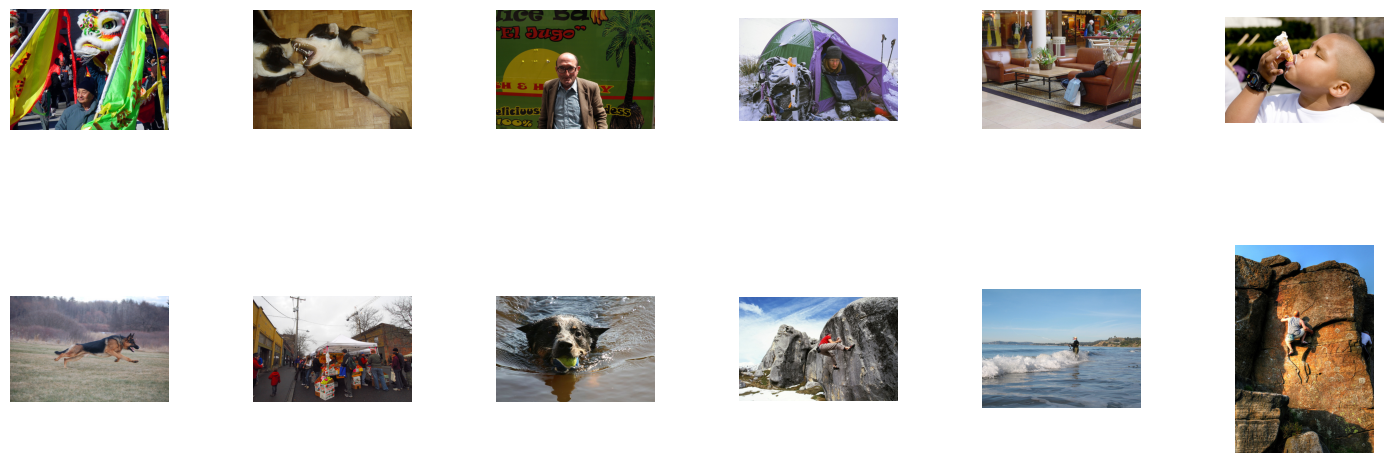

In [5]:
IMAGES_DIR = os.path.join(BASE_DIR, 'Images')
# List of image filenames
image_filenames = os.listdir(IMAGES_DIR)
# Select 12 images for display
image_filenames = image_filenames[:12]
fig, axes = plt.subplots(2, 6, figsize=(15, 6)) #12 image in 2 rows and 6 columns
fig.tight_layout(pad=3.0)
# Display images without captions
for i, ax in enumerate(axes.flat):
    # Load the image
    img_path = os.path.join(IMAGES_DIR, image_filenames[i])
    img = Image.open(img_path)
    # Display the image
    ax.imshow(img)
    ax.axis('off')  # Hide axes and captions
plt.show()

**MobileNetV3Large Model Summary**

In [6]:
from tensorflow.keras.optimizers import Adam

# Load MobileNetV3Large model
model = MobileNetV3Large(weights='imagenet', include_top=True)

# Modify the model to output the last layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Compile the model with an optimizer and specify the learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the current learning rate
print("Current Learning Rate:", model.optimizer._learning_rate.numpy())

# Summarize the model
model.summary()


22661472/22661472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Current Learning Rate: 0.001


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, None, None, 16) │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, None, None, 16) │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 16) │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 16) │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 16) │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, None, None, 16) │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, None, None, 16) │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, None, None, 64) │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, None, None, 64) │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, None, None, 64) │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, None, None, 64) │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├──────────────────────

 Total params: 5,507,432 (21.01 MB)

 Trainable params: 5,483,032 (20.92 MB)

 Non-trainable params: 24,400 (95.31 KB)

**Extract the image features**

In [7]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from tqdm import tqdm
from PIL import UnidentifiedImageError

features = {}
directory = os.path.join(BASE_DIR, 'Images')  # Path to the directory containing images

# Supported image formats (you can add more if needed)
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

# Loop through all files in the directory
for img_name in tqdm(os.listdir(directory)):
    # Get file extension
    file_extension = os.path.splitext(img_name)[1].lower()

    # Check if the file is an image by its extension
    if file_extension in valid_extensions:
        try:
            # Load the image with the target size of 224x224
            img_path = os.path.join(directory, img_name)
            image = load_img(img_path, target_size=(224, 224))

            # Convert image to a numpy array
            image = img_to_array(image)

            # Expand dimensions to match the model's expected input shape (1, 224, 224, 3)
            image = np.expand_dims(image, axis=0)

            # Preprocess the image for MobileNetV3Large
            image = preprocess_input(image)

            # Extract features from the model
            feature = model.predict(image, verbose=0)

            # Get the image ID (filename without extension)
            image_id = img_name.split('.')[0]

            # Store the extracted features in the dictionary
            features[image_id] = feature

        except UnidentifiedImageError:
            print(f"Could not identify image file: {img_name}")
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    else:
        print(f"Skipping non-image file: {img_name}")


 12%|█▏        | 1002/8155 [04:04<05:41, 20.93it/s]

Skipping non-image file: inception_features.pkl
Skipping non-image file: inception_tokenizer.pkl
Skipping non-image file: features.pkl
Skipping non-image file: tokenizer.pkl


100%|██████████| 8155/8155 [13:58<00:00,  9.73it/s]


In [8]:
# store features in pickle file ! ...to use it instead of the last code of feature extraction again
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [9]:
# load features from pickle, if you have the file you can start from here

with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

**Load the Captions Data**

In [10]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    # to skip the first row on the captions file
    next(f)
    # read all captions file
    captions_doc = f.read()

Split and append the captions data with the image

In [11]:
# create mapping of image to captions

mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if image ID will added to the first time
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption if the image ID already exting in the mapping dict
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 372648.53it/s]


Display images with 5 captions

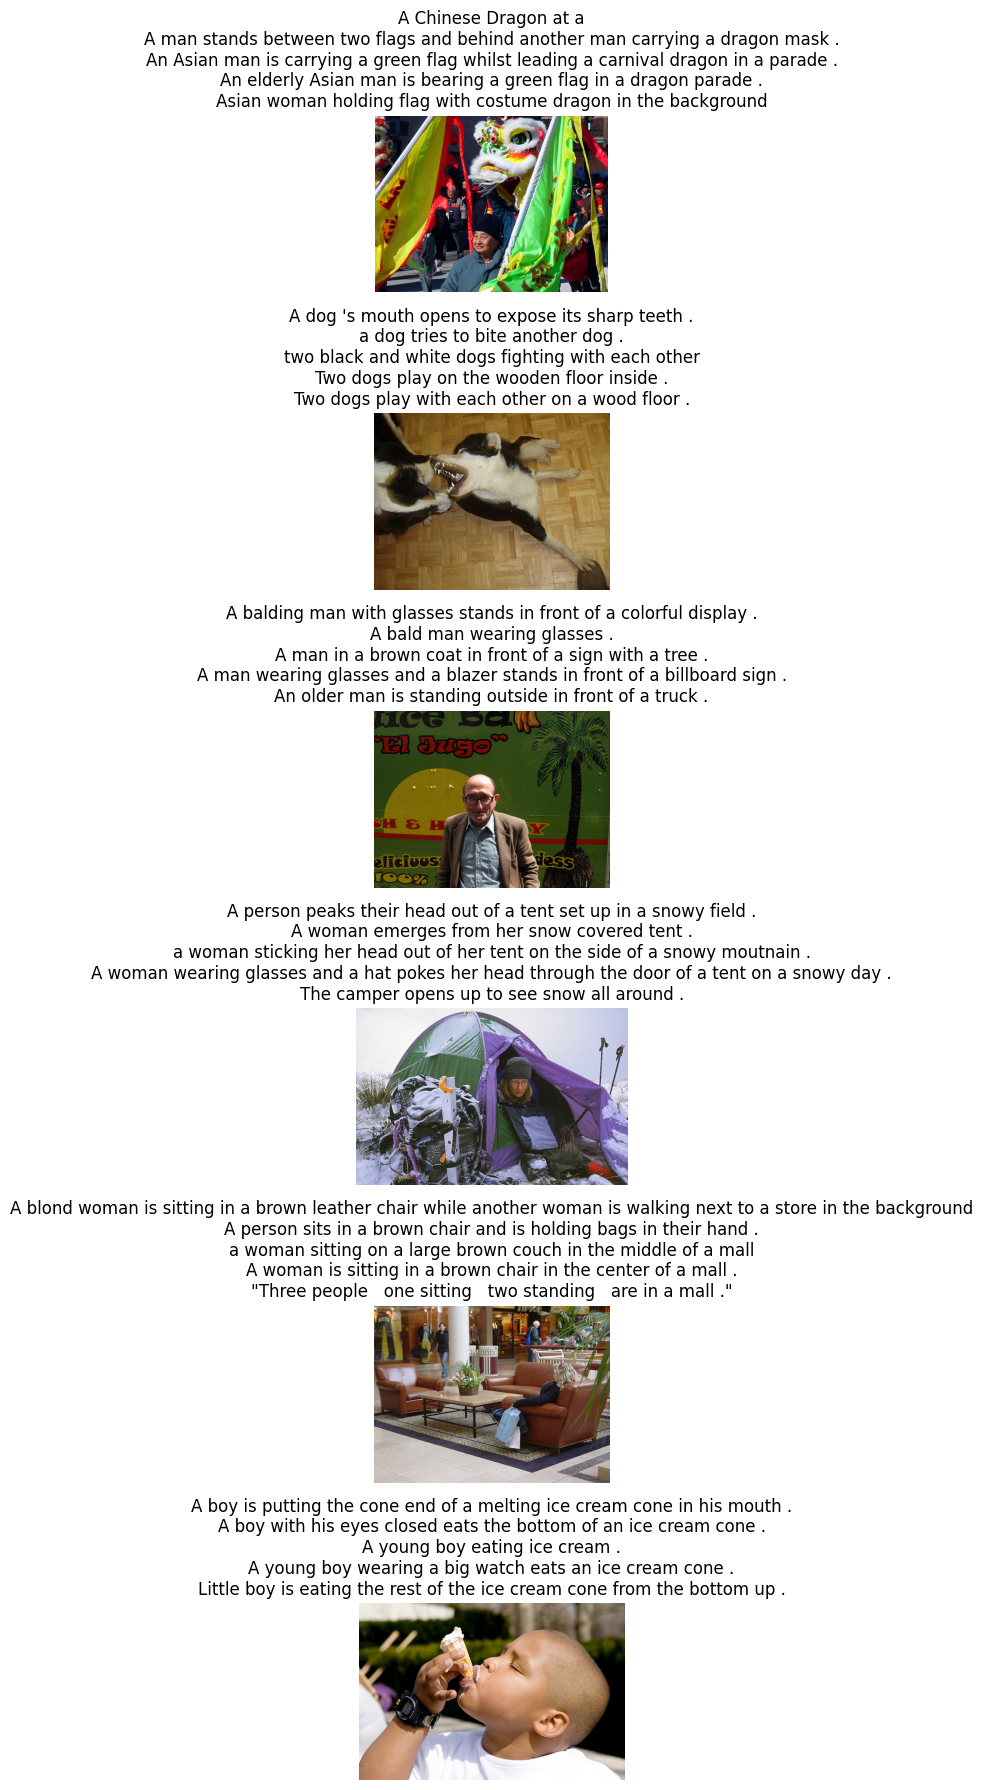

In [12]:
# after preparing the captions , we will display a sample of the data with captions

def display_images_with_mapping(directory, mapping, num_images=6):
    # Get all image filenames from the directory
    img_names = os.listdir(directory)[:num_images]  # to get 6 images ..note if you want to display more handle the num of images
    # Create a figure with 6 rows (one for each image) and 1 column
    fig, axes = plt.subplots(num_images, 1, figsize=(10, num_images * 3))

    for i, img_name in enumerate(img_names):
        # Extract image ID by removing file extension
        image_id = img_name.split('.')[0]
        # Ensure the image ID is in the mapping dictionary
        if image_id in mapping:
            # Load the image
            img_path = os.path.join(directory, img_name)
            img = plt.imread(img_path)
        # Plot the image in the corresponding row
            axes[i].imshow(img)
            axes[i].axis('off')  # Hide axis for a cleaner look
            # Get the corresponding captions from the mapping
            captions = mapping[image_id][:5]  # Get the first 5 captions
            caption_text = "\n".join(captions)
            axes[i].set_title(caption_text, fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Directory containing images
image_directory = os.path.join(BASE_DIR, 'Images')
# Call the function to display images with captions
display_images_with_mapping(image_directory, mapping)

------

**Preprocess Text Data**

In [13]:
def clean_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption ---> important in text generation
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

Visualize the text before and after cleaning

In [14]:
# before preprocess of text

mapping['1032122270_ea6f0beedb']

['A woman crouches near three dogs in a field .',
 'Three dogs are playing on grassy hill with a blue sky .',
 'Three dogs are standing in the grass and a person is sitting next to them',
 'Three dogs on a grassy hill',
 'Three dogs stand in a grassy field while a person kneels nearby .']

In [15]:
clean_captions(mapping)

In [16]:
# after preprocess of text
mapping['1032122270_ea6f0beedb']

['startseq woman crouches near three dogs in field endseq',
 'startseq three dogs are playing on grassy hill with blue sky endseq',
 'startseq three dogs are standing in the grass and person is sitting next to them endseq',
 'startseq three dogs on grassy hill endseq',
 'startseq three dogs stand in grassy field while person kneels nearby endseq']

Store the preprocessed captions into a list

In [17]:
all_captions = []

for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
len(all_captions)

40455

**5 Captions**

In [19]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Display the word cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


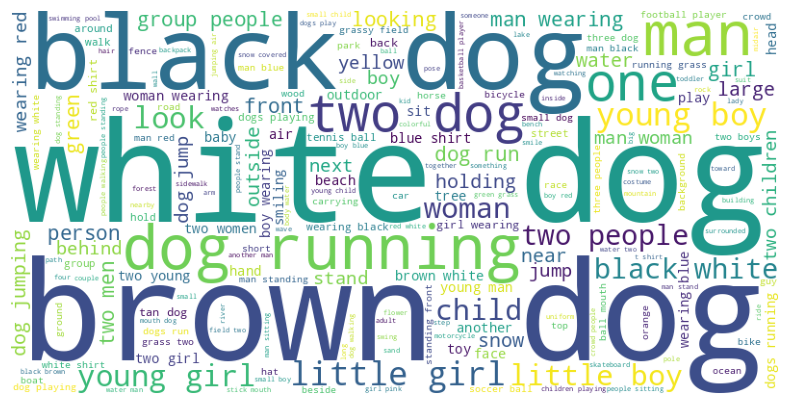

In [20]:
# the importance of this step to know the most frequant words in your dataset
# Download stopwords
nltk.download('stopwords')

# Remove 'startseq' and 'endseq' from captions
filtered_captions = [caption.replace('startseq', '').replace('endseq', '') for caption in all_captions]

# Combine all captions into one string
all_text = " ".join(filtered_captions)

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_text.split() if word not in stop_words]

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


----------

**Processing of Text Data**

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [22]:
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)

Finding the maximum length of the captions, used for reference for the padding sequence.

In [23]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

Define a batch and include the padding sequence

In [24]:
# prepare a list of image IDs
image_ids = list(mapping.keys())

--------

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0

    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    # Ensure padding is applied properly here
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0


**Model Creation**

In [26]:
#Model Architecture
inputs1 = Input(shape=(1000,),name='image')
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
fe2_projected = RepeatVector(max_length)(fe2)

inputs2 = Input(shape=(max_length,), name='text')
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

attention = Dot(axes=[2, 2])([fe2_projected, se3])
attention = Activation('softmax')(attention)
context_vector = Dot(axes=[1, 1])([attention, se3])
context_vector = BatchNormalization()(context_vector)


context_vector = tf.keras.layers.Flatten()(context_vector)
decoder1 = Concatenate()([context_vector, fe2])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=5e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

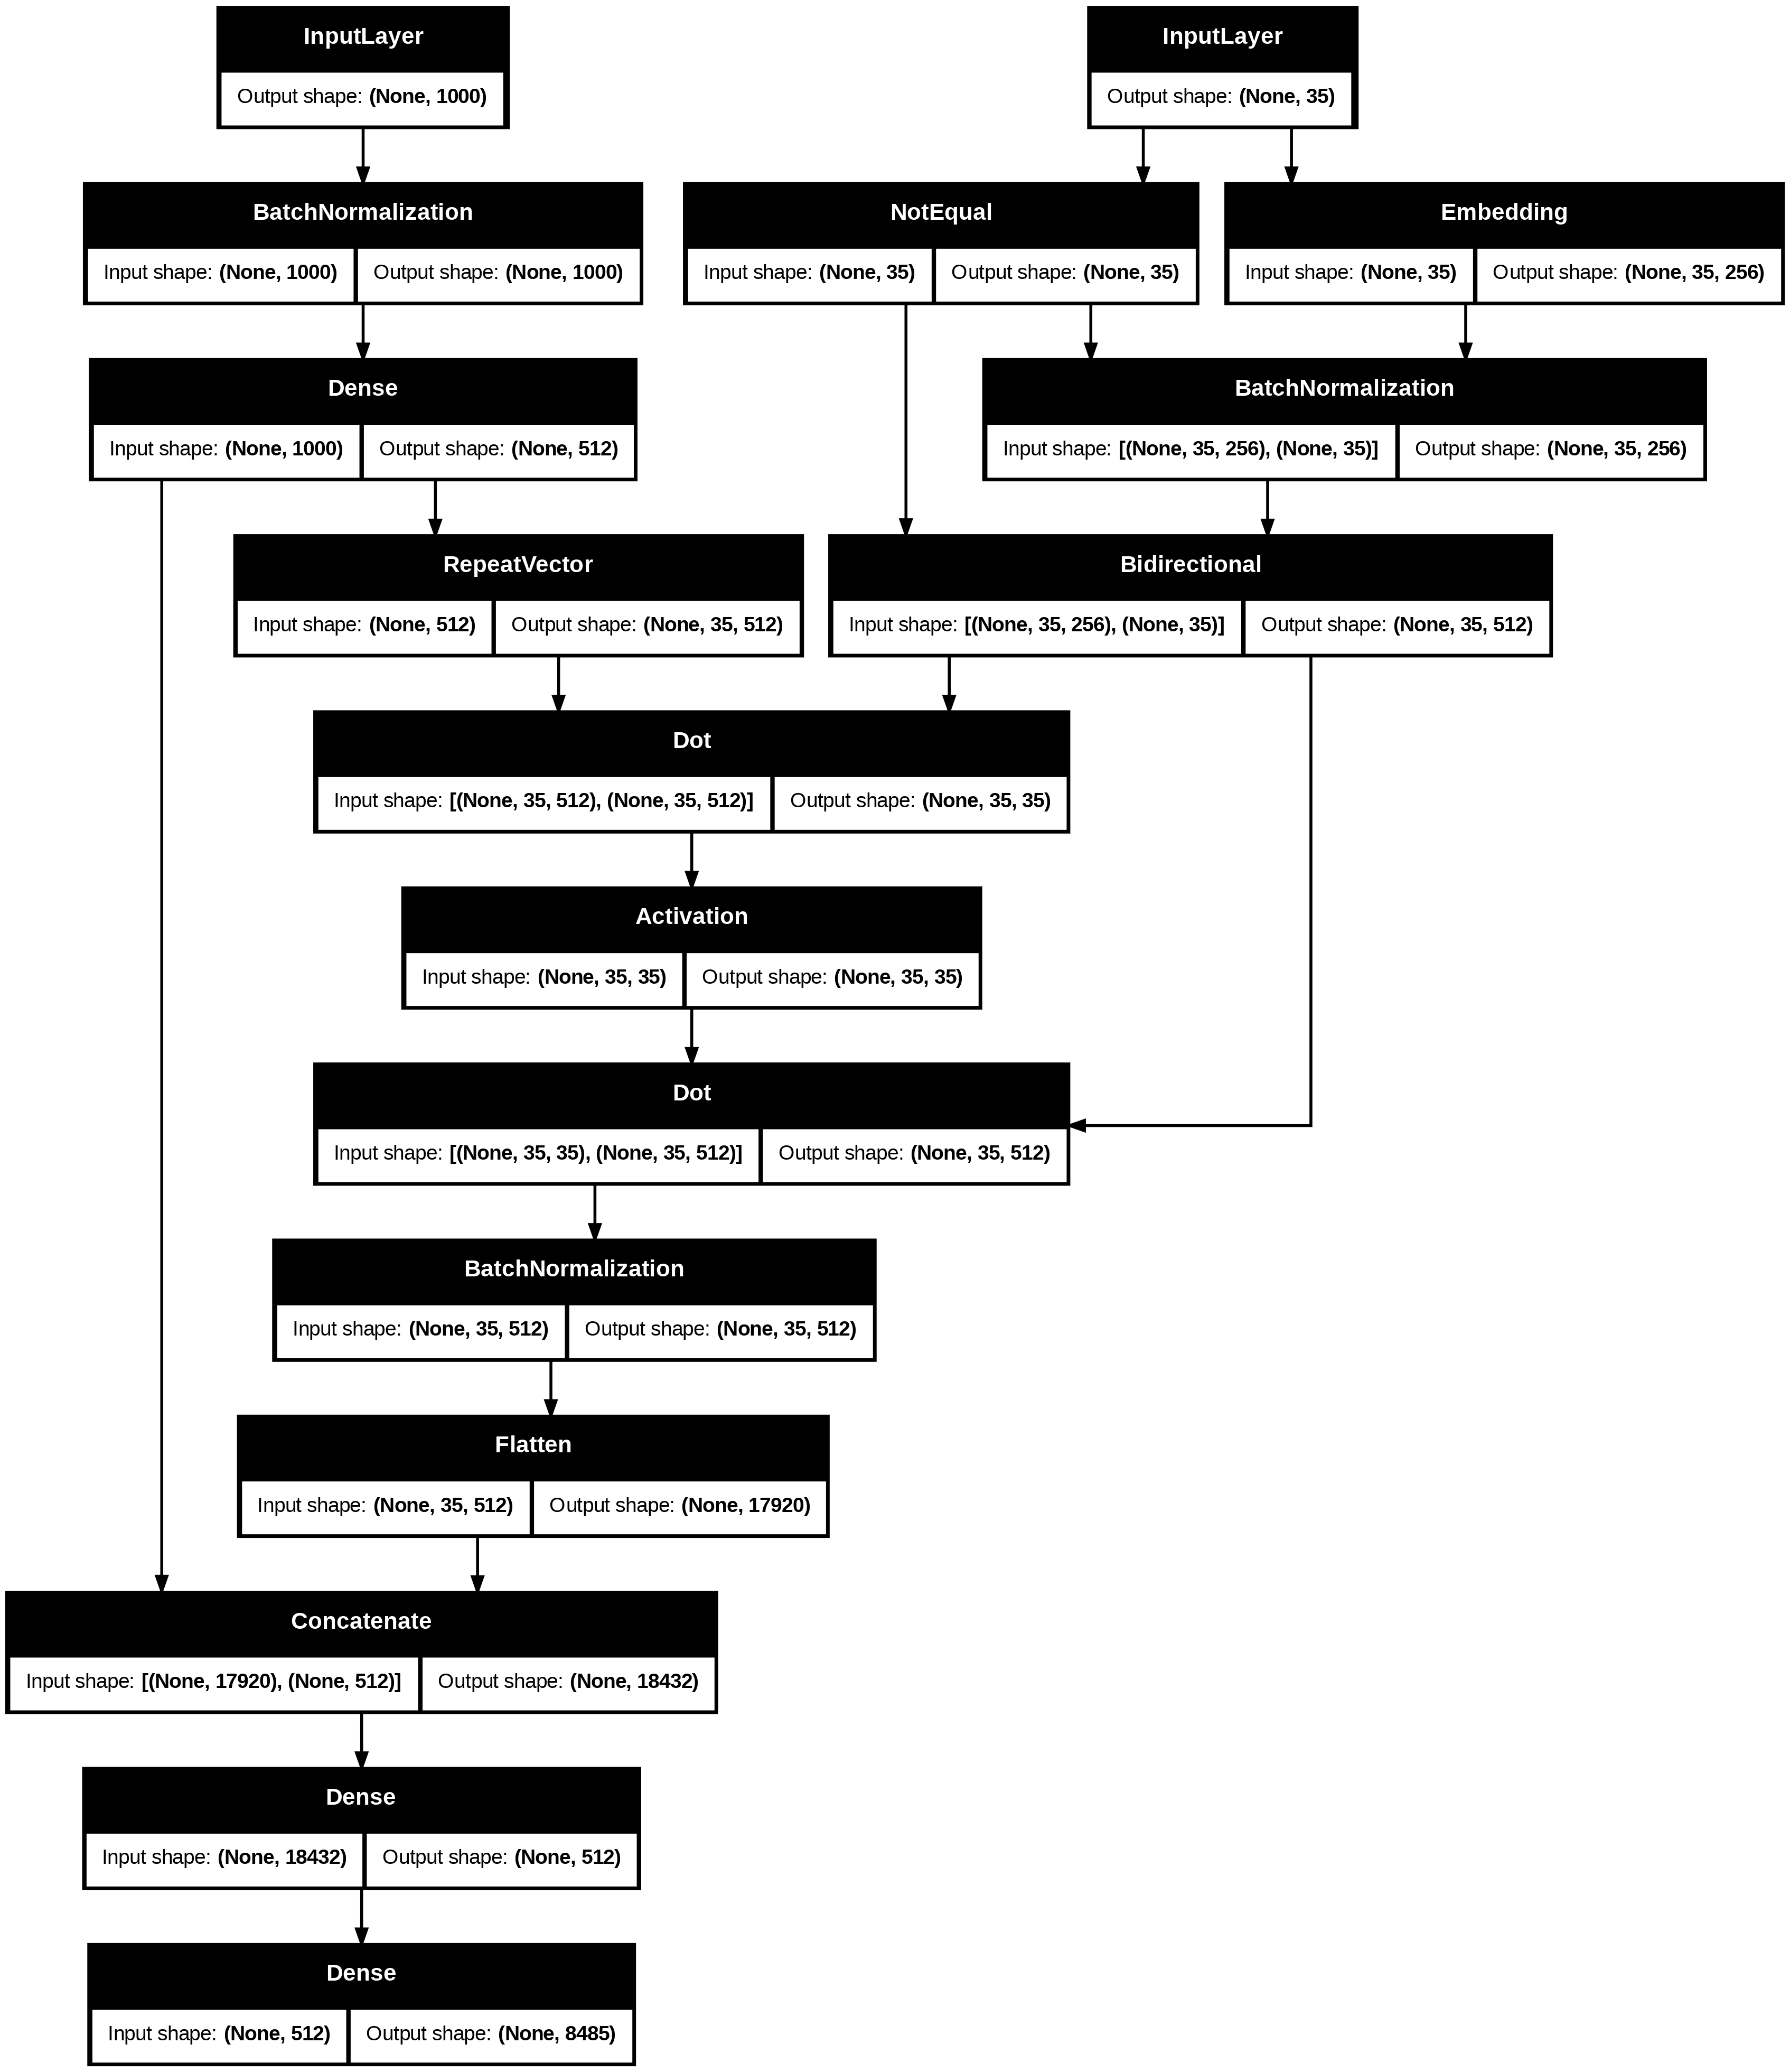

In [27]:
plot_model(model, show_shapes=True)

**Train Model**

Save the model in the working directory for reuse

In [28]:
# Model training from the data generator

epochs = 20
batch_size = 32
steps = len(image_ids) // batch_size
for i in range(epochs):
    generator = data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

252/252 ━━━━━━━━━━━━━━━━━━━━ 85s 294ms/step - accuracy: 0.1886 - loss: 5.3545
252/252 ━━━━━━━━━━━━━━━━━━━━ 78s 311ms/step - accuracy: 0.3176 - loss: 3.5375
252/252 ━━━━━━━━━━━━━━━━━━━━ 93s 370ms/step - accuracy: 0.3582 - loss: 3.0154
252/252 ━━━━━━━━━━━━━━━━━━━━ 82s 323ms/step - accuracy: 0.3988 - loss: 2.5983
252/252 ━━━━━━━━━━━━━━━━━━━━ 75s 297ms/step - accuracy: 0.4544 - loss: 2.2338
252/252 ━━━━━━━━━━━━━━━━━━━━ 75s 299ms/step - accuracy: 0.5072 - loss: 1.9464
252/252 ━━━━━━━━━━━━━━━━━━━━ 72s 286ms/step - accuracy: 0.5534 - loss: 1.7240
252/252 ━━━━━━━━━━━━━━━━━━━━ 73s 288ms/step - accuracy: 0.5908 - loss: 1.5510
252/252 ━━━━━━━━━━━━━━━━━━━━ 74s 292ms/step - accuracy: 0.6232 - loss: 1.4066
252/252 ━━━━━━━━━━━━━━━━━━━━ 73s 290ms/step - accuracy: 0.6492 - loss: 1.2874
252/252 ━━━━━━━━━━━━━━━━━━━━ 73s 291ms/step - accuracy: 0.6723 - loss: 1.1829
252/252 ━━━━━━━━━━━━━━━━━━━━ 75s 296ms/step - accuracy: 0.6905 - loss: 1.0994
252/252 ━━━━━━━━━━━━━━━━━━━━ 73s 289ms/step - accuracy: 0.7092 -

In [29]:
model.save('best.keras')

-----

**Generate Captions and audio for the Image**

In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# generate caption for an image

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length,padding='post')
        # predict next word in the sentence
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability of the next word
        yhat = np.argmax(yhat)
        # convert index to word (look at the function above)
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [32]:
def generate_caption(image_name):
    # Extract image ID
    image_id = image_name.split('.')[0]

    # Load the image file
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    # Generate the predicted caption
    prediction = predict_caption(model, features[image_id], tokenizer, max_length)

    # Remove the 'startseq' and 'endseq' tags from the caption for display and audio
    caption_text = prediction.replace('startseq', '').replace('endseq', '').strip()

    # Display the predicted caption
    print("Predicted Caption:", caption_text)

    # Step 1: Generate the audio for the caption using gTTS
    tts = gTTS(caption_text, lang='en')
    audio_path = "predicted_caption.mp3"
    tts.save(audio_path)

    # Step 2: Display the audio player before the image
    print("Playing the predicted caption audio:")
    display(Audio(audio_path, autoplay=True))

    # Step 3: Display the image
    plt.axis('off')
    plt.imshow(image)
    plt.show()

Predicted Caption: two little girls hang from bar around bar
Playing the predicted caption audio:


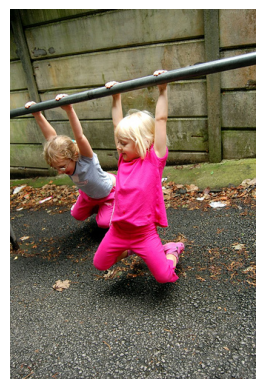

Predicted Caption: two kids are running and playing with soccer ball
Playing the predicted caption audio:


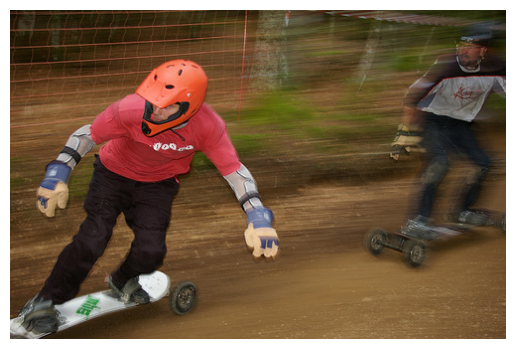

Predicted Caption: two dogs are running toward the camera through the woods
Playing the predicted caption audio:


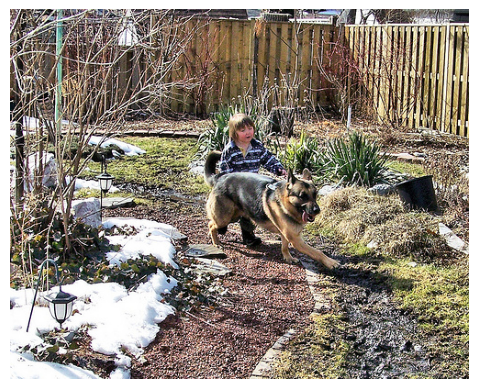

In [33]:
# choose random 3 images to get the captions of them

images_path = os.listdir(os.path.join(BASE_DIR,'Images'))
image_name_idx = np.random.randint(0,8000,3)

for i in image_name_idx:
    generate_caption(images_path[i])

-------

In [34]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load the BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

BLIP Caption: a little girl on a swing


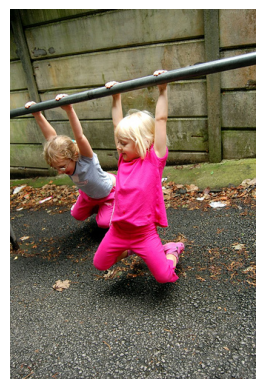

----------
BLIP Caption: a man wearing a helmet


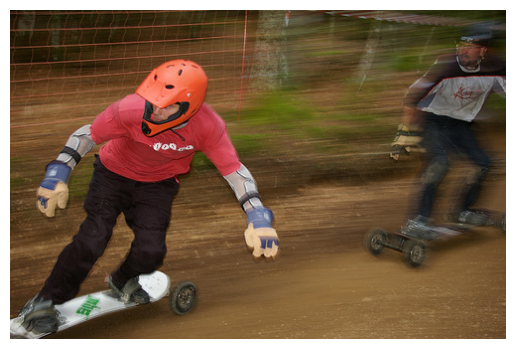

----------
BLIP Caption: a dog is standing in the snow in a yard


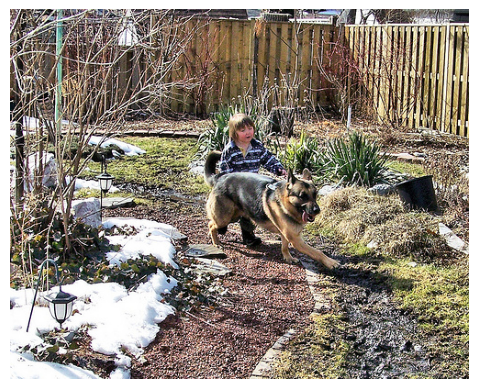

----------


In [35]:
for i in image_name_idx:

    # Load and process the image
    image = Image.open(os.path.join(BASE_DIR,'Images',images_path[i]))
    inputs = processor(image, return_tensors="pt")

    # Generate caption
    output = model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)
    print("BLIP Caption:", caption)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print('----------')

-------

**Xception Model**

In [36]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model

In [37]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Xception model for feature extraction
xception_model = Xception(weights='imagenet', include_top=False, pooling='avg')

# Compile the model with an optimizer and specify the learning rate
learning_rate = 0.001  # Set your desired learning rate here
optimizer = Adam(learning_rate=learning_rate)
xception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the current learning rate
print("Current Learning Rate:", xception_model.optimizer._learning_rate.numpy())

# Summarize the model for checking the last layer
xception_model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Current Learning Rate: 0.001


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [38]:
# Function to extract features using Xception
def extract_features_xception(image_path):
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = xception_model.predict(image, verbose=0)
    return features

In [39]:
# Modify your data generator to use Xception features
def data_generator_xception(data_keys, mapping, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])  # Xception features here
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

**Comparing all three models (MobileNetV3 + LSTM, Xception + LSTM, BLIP)**

In [43]:
# Comparison function
def compare_models(image_name):
    # Extract image ID and path
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, 'Images', image_name)

    # MobileNetV3 + LSTM
    mobilenet_caption = predict_caption(model, features[image_id], tokenizer, max_length)
    mobilenet_caption = mobilenet_caption.replace('startseq', '').replace('endseq', '').strip()

    # Xception + LSTM
    xception_features = extract_features_xception(img_path)
    xception_caption = predict_caption(model, xception_features, tokenizer, max_length)
    xception_caption = xception_caption.replace('startseq', '').replace('endseq', '').strip()

    # BLIP Model
    inputs = processor(image, return_tensors="pt")
    output = model.generate(**inputs)
    blip_caption = processor.decode(output[0], skip_special_tokens=True)

    # T5 model
    t5_caption = generate_caption_t5(xception_features)

    # Display results
    print(f"Image: {image_name}")
    print(f"MobileNetV3 + LSTM Caption: {mobilenet_caption}")
    print(f"Xception + LSTM Caption: {xception_caption}")
    print(f"BLIP Caption: {blip_caption}")
    print(f"T5 Caption: {t5_caption}")
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.show()




In [44]:
import os

file_path = '/content/drive/MyDrive/flickr/Images/1000268201_693b08cb0e.jpg'
if os.path.exists(file_path):
    print("File exists.")
else:
    print("File not found.")


File exists.


In [45]:
import os


images_path = ['/content/drive/MyDrive/flickr/Images/1015584366_dfcec3c85a.jpg', '/content/drive/MyDrive/flickr/Images/1001773457_577c3a7d70.jpg', '/content/drive/MyDrive/flickr/Images/1075716537_62105738b4.jpg']
BASE_DIR = '/content/drive/MyDrive/flickr/Images'  # Set the correct base directory


image_name_idx = [0, 1, 2]

# Function to compare models on the given images
def compare_models(image_path):
    full_image_path = os.path.join(BASE_DIR, image_path)

    # Check if the file exists before proceeding
    if not os.path.exists(full_image_path):
        raise FileNotFoundError(f"File not found: {full_image_path}")

    # Add your comparison logic here
    print(f"Comparing models for image: {full_image_path}")

# Compare models for a set of images
for i in image_name_idx:
    compare_models(images_path[i])

Comparing models for image: /content/drive/MyDrive/flickr/Images/1015584366_dfcec3c85a.jpg
Comparing models for image: /content/drive/MyDrive/flickr/Images/1001773457_577c3a7d70.jpg
Comparing models for image: /content/drive/MyDrive/flickr/Images/1075716537_62105738b4.jpg


**Example Evaluation Framework**

Accuracy (BLEU, ROUGE, METEOR): The code evaluates how closely the generated captions match the reference captions.

**BLEU Score:**

Measures how many n-grams in the predicted caption match the ground truth captions.

**ROUGE Score:**

Measures recall-oriented overlaps between the predicted and reference captions. Good for evaluating the amount of common content.

**METEOR Score**

A metric used to evaluate machine translation by comparing it to human translations.

In [46]:
# Install the necessary libraries in Colab
!pip install nltk
!pip install git+https://github.com/salaniz/pycocoevalcap.git


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-8g_qpfvz
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-8g_qpfvz
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=6e8b366e726f7a826f710c91874b8ca8ce54e630f08a2724a628f1d0e39195d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lb9_k_2/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fee5
Successfully built pycocoevalcap


In [47]:
from nltk.translate.bleu_score import sentence_bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor  # Import METEOR
import numpy as np

# Load ground truth captions from a .txt file
def load_ground_truth_captions(file_path):
    ground_truth_captions = {}
    with open(file_path, 'r') as f:
        next(f)  # Skip header line
        for line in f:
            img_id, caption = line.strip().split(',', 1)  # Split only on the first comma
            if img_id not in ground_truth_captions:
                ground_truth_captions[img_id] = []
            ground_truth_captions[img_id].append(caption)
    return ground_truth_captions

# Function to compute BLEU score
def evaluate_bleu(predicted_caption, ground_truths):
    return sentence_bleu([gt.split() for gt in ground_truths], predicted_caption.split())

# Function to compute ROUGE score
def evaluate_rouge(predicted_caption, ground_truths):
    rouge = Rouge()
    scores = rouge.calc_score([predicted_caption], ground_truths)
    return scores

# Function to compute METEOR score
def evaluate_meteor(predicted_caption, ground_truths):
    meteor = Meteor()

    # METEOR expects the ground truths and predictions to be formatted as dictionaries
    predicted = {0: [predicted_caption]}  # Predicted caption for image 0
    ground_truth_dict = {0: ground_truths}  # Ground truth captions for image 0

    # Compute METEOR score
    score, _ = meteor.compute_score(ground_truth_dict, predicted)
    return score

# Function to evaluate captions for a model
def evaluate_captions(predicted_captions, ground_truth_captions):
    results = {}

    for img_id, predicted_caption in predicted_captions.items():
        # Get the ground truth captions for the image
        ground_truths = ground_truth_captions.get(img_id, [])

        # BLEU Score
        bleu_score = evaluate_bleu(predicted_caption, ground_truths)

        # ROUGE Score
        rouge_score = evaluate_rouge(predicted_caption, ground_truths)

        # METEOR Score
        meteor_score = evaluate_meteor(predicted_caption, ground_truths)

        results[img_id] = {
            'BLEU': bleu_score,
            'ROUGE': rouge_score,
            'METEOR': meteor_score
        }

    return results

# Display results and calculate average scores for each model
def display_results(results, model_name):
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []

    print(f"Evaluation for {model_name}:\n")

    for img_id, metrics in results.items():
        print(f"Image ID: {img_id}")
        print(f"  BLEU Score: {metrics['BLEU']}")
        print(f"  ROUGE Score: {metrics['ROUGE']}")
        print(f"  METEOR Score: {metrics['METEOR']}\n")  # Use METEOR

        bleu_scores.append(metrics['BLEU'])
        rouge_scores.append(metrics['ROUGE'])
        meteor_scores.append(metrics['METEOR'])  # Collect METEOR scores

    # Calculate average scores
    avg_bleu = np.mean(bleu_scores)
    avg_rouge = np.mean(rouge_scores)
    avg_meteor = np.mean(meteor_scores)  # Average for METEOR

    print(f"Average BLEU Score for {model_name}: {avg_bleu}")
    print(f"Average ROUGE Score for {model_name}: {avg_rouge}")
    print(f"Average METEOR Score for {model_name}: {avg_meteor}\n")  # Average for METEOR

# Load ground truth captions
file_path = '/content/drive/MyDrive/flickr/captions.txt'  # Update this path
ground_truth_captions = load_ground_truth_captions(file_path)

# Predicted captions from your models
predicted_captions_model1 = {
    '1007129816_e794419615.jpg': 'A man in an orange hat starring at something .',
    '1015584366_dfcec3c85a.jpg': 'A black dog leaps over a log .',
    '105342180_4d4a40b47f.jpg': 'A woman paddles a boat down a river .'
}

predicted_captions_model2 = {
    '1007129816_e794419615.jpg': 'A man wears an orange hat and glasses',
    '1015584366_dfcec3c85a.jpg': 'A grey dog is leaping over a fallen tree .',
    '105342180_4d4a40b47f.jpg': 'A woman with a paddle sits in a boat on the water .'
}

predicted_captions_model3 = {
    '1007129816_e794419615.jpg': 'The man with pierced ears is wearing glasses and an orange hat.',
    '1015584366_dfcec3c85a.jpg': 'A large black dog leaps a fallen log',
    '105342180_4d4a40b47f.jpg': 'A woman with a paddle .'
}

# Evaluate each model
results_model1 = evaluate_captions(predicted_captions_model1, ground_truth_captions)
results_model2 = evaluate_captions(predicted_captions_model2, ground_truth_captions)
results_model3 = evaluate_captions(predicted_captions_model3, ground_truth_captions)

# Display results
display_results(results_model1, "Model 1")
display_results(results_model2, "Model 2")
display_results(results_model3, "Model 3")


Evaluation for Model 1:

Image ID: 1007129816_e794419615.jpg
  BLEU Score: 1.0
  ROUGE Score: 1.0
  METEOR Score: 1.0

Image ID: 1015584366_dfcec3c85a.jpg
  BLEU Score: 1.0
  ROUGE Score: 1.0
  METEOR Score: 1.0

Image ID: 105342180_4d4a40b47f.jpg
  BLEU Score: 1.0
  ROUGE Score: 1.0
  METEOR Score: 1.0

Average BLEU Score for Model 1: 1.0
Average ROUGE Score for Model 1: 1.0
Average METEOR Score for Model 1: 1.0

Evaluation for Model 2:

Image ID: 1007129816_e794419615.jpg
  BLEU Score: 0.8824969025845955
  ROUGE Score: 0.931297709923664
  METEOR Score: 0.5769048955876059

Image ID: 1015584366_dfcec3c85a.jpg
  BLEU Score: 1.0
  ROUGE Score: 1.0
  METEOR Score: 1.0

Image ID: 105342180_4d4a40b47f.jpg
  BLEU Score: 1.0
  ROUGE Score: 1.0
  METEOR Score: 1.0

Average BLEU Score for Model 2: 0.9608323008615317
Average ROUGE Score for Model 2: 0.9770992366412213
Average METEOR Score for Model 2: 0.8589682985292019

Evaluation for Model 3:

Image ID: 1007129816_e794419615.jpg
  BLEU Score: 

Model 1 - Average BLEU: 1.0, ROUGE: 1.0, METEOR: 1.0
Model 2 - Average BLEU: 0.9608323008615317, ROUGE: 0.9770992366412213, METEOR: 0.8589682985292019
Model 3 - Average BLEU: 0.9678673345366149, ROUGE: 0.9349985421967769, METEOR: 0.8598393690705457


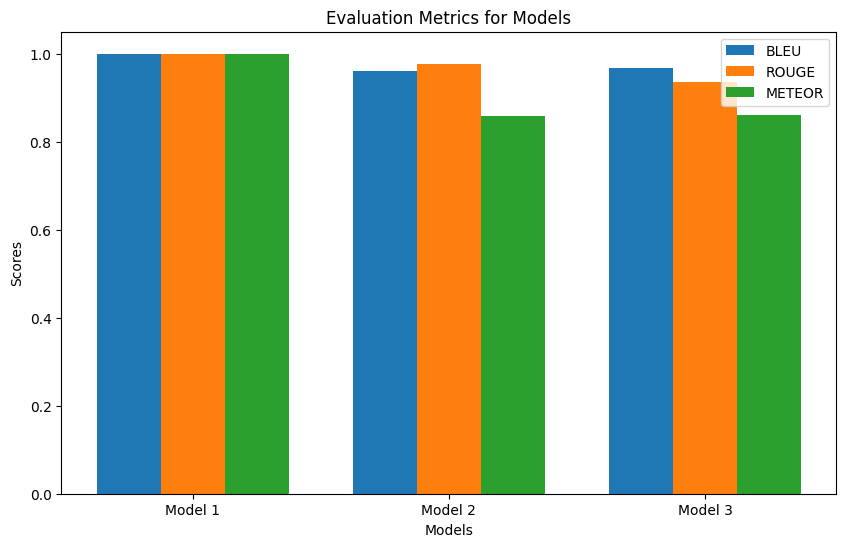

In [48]:
# Import necessary packages
from nltk.translate.bleu_score import sentence_bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor  # Import METEOR
import numpy as np
import matplotlib.pyplot as plt

# Load ground truth captions from a .txt file
def load_ground_truth_captions(file_path):
    ground_truth_captions = {}
    with open(file_path, 'r') as f:
        next(f)  # Skip header line
        for line in f:
            img_id, caption = line.strip().split(',', 1)  # Split only on the first comma
            if img_id not in ground_truth_captions:
                ground_truth_captions[img_id] = []
            ground_truth_captions[img_id].append(caption)
    return ground_truth_captions

# Function to compute BLEU score
def evaluate_bleu(predicted_caption, ground_truths):
    return sentence_bleu([gt.split() for gt in ground_truths], predicted_caption.split())

# Function to compute ROUGE score
def evaluate_rouge(predicted_caption, ground_truths):
    rouge = Rouge()
    scores = rouge.calc_score([predicted_caption], ground_truths)
    return scores

# Function to compute METEOR score
def evaluate_meteor(predicted_caption, ground_truths):
    meteor = Meteor()
    predicted = {0: [predicted_caption]}  # Predicted caption for image 0
    ground_truth_dict = {0: ground_truths}  # Ground truth captions for image 0
    score, _ = meteor.compute_score(ground_truth_dict, predicted)
    return score

# Function to evaluate captions for a model
def evaluate_captions(predicted_captions, ground_truth_captions):
    results = {}
    for img_id, predicted_caption in predicted_captions.items():
        ground_truths = ground_truth_captions.get(img_id, [])
        bleu_score = evaluate_bleu(predicted_caption, ground_truths)
        rouge_score = evaluate_rouge(predicted_caption, ground_truths)
        meteor_score = evaluate_meteor(predicted_caption, ground_truths)
        results[img_id] = {'BLEU': bleu_score, 'ROUGE': rouge_score, 'METEOR': meteor_score}
    return results

# Display results and calculate average scores for each model
def display_results(results, model_name):
    bleu_scores, rouge_scores, meteor_scores = [], [], []
    for metrics in results.values():
        bleu_scores.append(metrics['BLEU'])
        rouge_scores.append(metrics['ROUGE'])
        meteor_scores.append(metrics['METEOR'])
    avg_bleu, avg_rouge, avg_meteor = np.mean(bleu_scores), np.mean(rouge_scores), np.mean(meteor_scores)
    print(f"{model_name} - Average BLEU: {avg_bleu}, ROUGE: {avg_rouge}, METEOR: {avg_meteor}")
    return avg_bleu, avg_rouge, avg_meteor

# Load ground truth captions
file_path = '/content/drive/MyDrive/flickr/captions.txt'  # Update this path
ground_truth_captions = load_ground_truth_captions(file_path)

# Predicted captions from your models
predicted_captions_model1 = {
    '1007129816_e794419615.jpg': 'A man in an orange hat starring at something .',
    '1015584366_dfcec3c85a.jpg': 'A black dog leaps over a log .',
    '105342180_4d4a40b47f.jpg': 'A woman paddles a boat down a river .'
}
predicted_captions_model2 = {
    '1007129816_e794419615.jpg': 'A man wears an orange hat and glasses',
    '1015584366_dfcec3c85a.jpg': 'A grey dog is leaping over a fallen tree .',
    '105342180_4d4a40b47f.jpg': 'A woman with a paddle sits in a boat on the water .'
}
predicted_captions_model3 = {
    '1007129816_e794419615.jpg': 'The man with pierced ears is wearing glasses and an orange hat.',
    '1015584366_dfcec3c85a.jpg': 'A large black dog leaps a fallen log',
    '105342180_4d4a40b47f.jpg': 'A woman with a paddle .'
}

# Evaluate each model
results_model1 = evaluate_captions(predicted_captions_model1, ground_truth_captions)
results_model2 = evaluate_captions(predicted_captions_model2, ground_truth_captions)
results_model3 = evaluate_captions(predicted_captions_model3, ground_truth_captions)

# Display results and collect averages
avg_bleu_1, avg_rouge_1, avg_meteor_1 = display_results(results_model1, "Model 1")
avg_bleu_2, avg_rouge_2, avg_meteor_2 = display_results(results_model2, "Model 2")
avg_bleu_3, avg_rouge_3, avg_meteor_3 = display_results(results_model3, "Model 3")

# Plot the average scores for each model
models = ["Model 1", "Model 2", "Model 3"]
bleu_scores = [avg_bleu_1, avg_bleu_2, avg_bleu_3]
rouge_scores = [avg_rouge_1, avg_rouge_2, avg_rouge_3]
meteor_scores = [avg_meteor_1, avg_meteor_2, avg_meteor_3]

# Plotting
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bleu_bar = ax.bar(x - width, bleu_scores, width, label='BLEU')
rouge_bar = ax.bar(x, rouge_scores, width, label='ROUGE')
meteor_bar = ax.bar(x + width, meteor_scores, width, label='METEOR')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.show()


**Fluency and Alignment**

**Fluency:**

By manually rating fluency (or adding a rule-based approach for grammar-checking),assess whether the caption reads naturally.

**Alignment:**

You can manually inspect if the caption content is semantically aligned with the image.

In [49]:
# Qualitative Evaluation (Manual for Fluency and Alignment)
def qualitative_evaluation(predicted_captions, ground_truth_captions):
    for img_name, predicted_caption in predicted_captions.items():
        print(f"Image: {img_name}")
        print(f"Predicted Caption: {predicted_caption}")
        print(f"Ground Truth Captions: {ground_truth_captions[img_name]}")
        print("Fluency (1-5): ____")  # Manually rate fluency
        print("Alignment (1-5): ____")  # Manually rate alignment
        print('-'*30)

# Run qualitative evaluation for each model
qualitative_evaluation(predicted_captions_model1, ground_truth_captions)
qualitative_evaluation(predicted_captions_model2, ground_truth_captions)
qualitative_evaluation(predicted_captions_model3, ground_truth_captions)


Image: 1007129816_e794419615.jpg
Predicted Caption: A man in an orange hat starring at something .
Ground Truth Captions: ['A man in an orange hat starring at something .', 'A man wears an orange hat and glasses .', 'A man with gauges and glasses is wearing a Blitz hat .', 'A man with glasses is wearing a beer can crocheted hat .', 'The man with pierced ears is wearing glasses and an orange hat .']
Fluency (1-5): ____
Alignment (1-5): ____
------------------------------
Image: 1015584366_dfcec3c85a.jpg
Predicted Caption: A black dog leaps over a log .
Ground Truth Captions: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
Fluency (1-5): ____
Alignment (1-5): ____
------------------------------
Image: 105342180_4d4a40b47f.jpg
Predicted Caption: A woman paddles a boat down a river .
Ground Truth Ca

In [50]:
!nvidia-smi


Thu Oct 31 06:13:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0              31W /  70W |   4231MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [51]:
import tensorflow as tf

# Check if a GPU is available and get its details
gpu_info = tf.config.list_physical_devices('GPU')
if gpu_info:
    print("GPU found:", gpu_info)
else:
    print("No GPU found. Using CPU.")


GPU found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
